# Fruit ispection

The purposes of this work were to better understand and get to work on some of the topics that were covered during the theoretical lectures. In particular, the project is divided in three main parts:
* First Task: Where I had to detect the shape of some apples and then locate some defects on the surface of the fruits;
* Second Task: The aim of this part was to identify some rusty parts on some other apples focusing on not highlighting false positive areas;
* Final challenge: Basically the purpose of this last task was the same of the first one but the detection of the shapes of the fruits here was more challenging due to the presence of others elements inside the pictures.

# First Task: fruit segmentation and defect detection

This task was aimed to outline some fruits (in particular, three apples) cutting them out from the background and then, since they present some defects on the surfaces, identify them.

I divided this first task in two parts: in the first one I will use thresholding and the flood-fil algorithm in order to obtain a binary mask for each fruit, while in the second one the defects in each fruit will be detected using an edge detector.

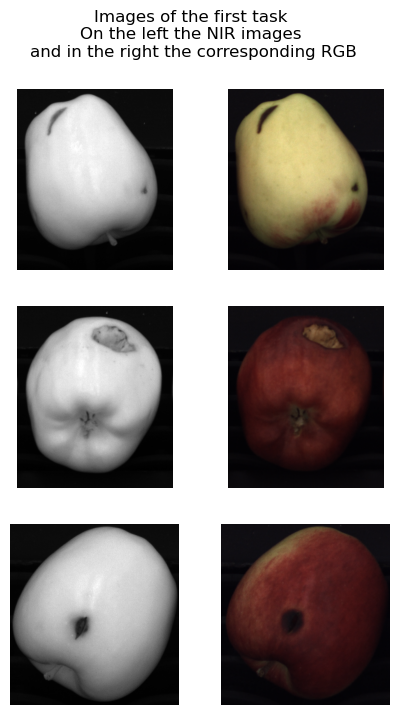

In [1]:
#imports
import cv2 
import numpy as np
from matplotlib import pyplot as plt

#look at 'cv_functions.py'
import cv_functions 

#load NIR and color images
NIR_imgs, COLOR_imgs = cv_functions.load_images('first task', ['01', '02', '03'])

#Plot images
cv_functions.show_fruit(NIR_imgs, 5, 8, 'Images of the first task \nOn the left the NIR images \nand in the right the corresponding RGB', COLOR_imgs)


## First part: Outline the fruit by generating a binary mask

### Histograms

Here I had the first choice of the project: choose the NIR or the colored images? I chose the NIR ones:
* They are better for detecting the fruits' shapes because their borders are better separated from the background since in the colored ones there are some dark areas all arround the fruits (maybe due to the light used fot the photos) that the algorithms can confuse for background;

* Thay are a way batter to perform defects detection becuse each defect is very well visible and if, for example, we look at the last NIR image we can see that the shape of the defect is perfect while in the corresponding RGB image it is 'smoothed'. Having well shaped defects could be useful to avoid the detections of other areas that could seems defects but they aren't (like the sepals of the apple in the second image).

Now, to achieve the first part of this first task I created a binary mask of the fruits. In order to do that, the way to proceed is to use a thresholding algorithm to separate the background from the foreground.
In the next cell I plotted the gray-levels histograms of the 3 images in order to understand if it could be possible to use a fixed hard-coded threshold (equal for all the images) or if it is better to go with the Otsu's algorithm or even with an adaptive approach.

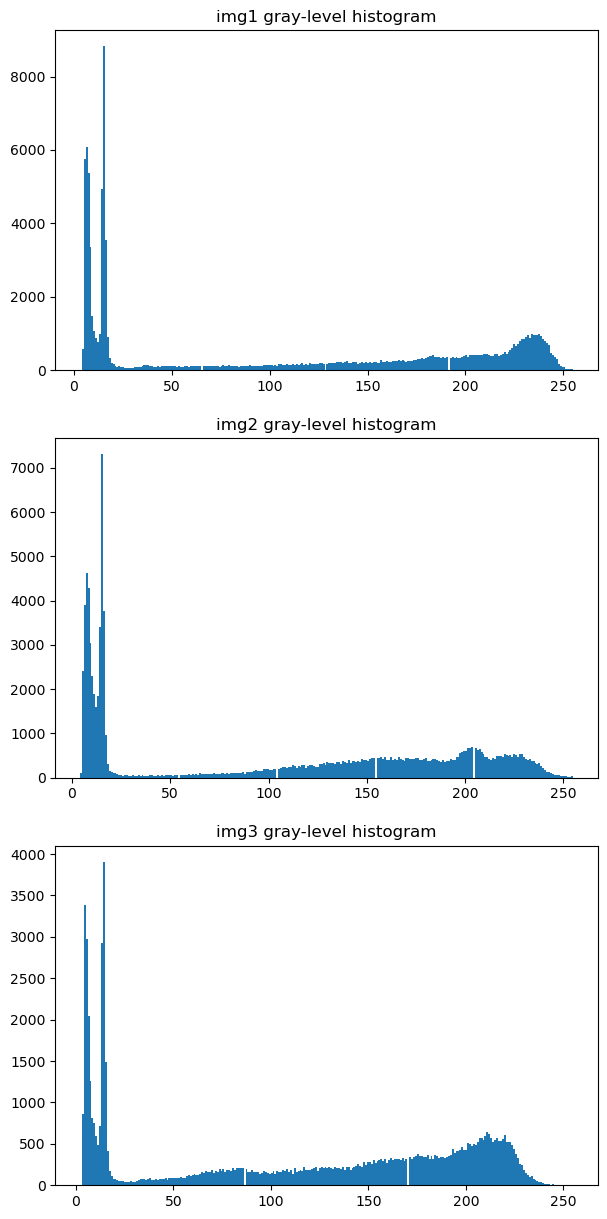

In [2]:
cv_functions.plot_hists(NIR_imgs)

### Thresholding using a fixed threshold

Looking at the histograms it is clear that a threshold between 25 and 70 could fit all the images, so I decided to go with an hard-coded threshold given its good execution time if compared with Otsu's algorithm or with the adaptive thresholding.

After a little bit of tuning I ended up with 60 that gives good results with all the 3 apples.
But now we have two new problems:
* the first one is that, especially in the last image, a part of the fruit is missing;
* the second one is that in the first and in the second images there are some little points in the background that are, for the moment, considered as foreground.

I tried also to use Otsu's algorithm and the adaptive thresholding techniques, but the results were worse.

### Otsu's algorithm and adaptive thresholding

Before going on, I'd like to point out that for a real world application, since it might be difficult to identify a threshold that fits all the possible images (unless we are sure that all the photos were taken under precise lighting conditions and with an always equal background), using the Otusu's algorithm or the adaptive thresholding could lead to better overall performances.

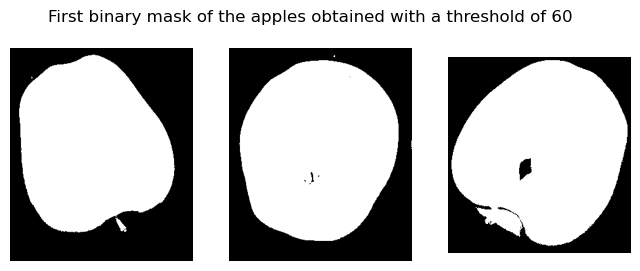

In [3]:
thresholded_imgs = [cv_functions.thresholding(img,60) for img in NIR_imgs]
cv_functions.show_fruit(thresholded_imgs,8,3, 'First binary mask of the apples obtained with a threshold of 60')

### flood-fil algorithm

The solution to the first problem is very strainghtforward: it is sufficient (as required) to apply the flood-fill algorithm and then apply a bitwise-or between the masks identified by the thresholding and those identified by the flood-fill algorithm.

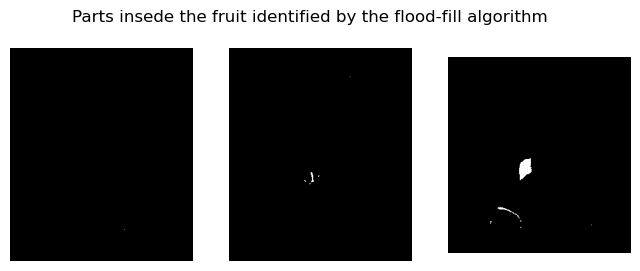

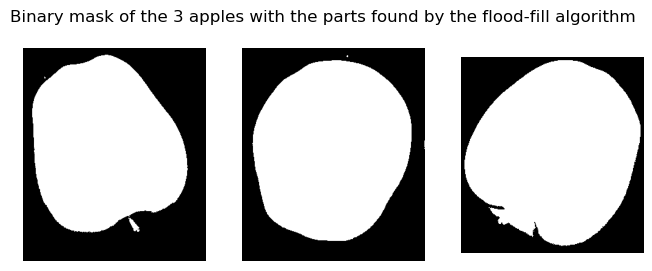

In [4]:
flooded_imgs = [cv_functions.apply_flood_fil(img) for img in thresholded_imgs]
#detected points inside the fruit
cv_functions.show_fruit(flooded_imgs,8,3,'Parts insede the fruit identified by the flood-fill algorithm')
final_shapes = cv_functions.get_complete_shape(flooded_imgs, thresholded_imgs)
cv_functions.show_fruit(final_shapes,8,3, 'Binary mask of the 3 apples with the parts found by the flood-fill algorithm')

### Using the median blur to remove some imperfections

To solve the second broblem the white 'points' in the background reminded me the impulse noise and so I used a medianBlur to remove them since it is the best filter to do that. 
Even if the image are binary images the use of this particular non-linear filter is permitted because the median blur could act like a morfological operator (in the sense that it is impossible for this filter to add grey levels to a given binary image). I chose to use the medianBlur insted of dilating the background because in this way the identified shapes of the fruits are better preserved. I chose a quite big kernel size for the filter in order to complitly remove a line of white pixels on the right of the second image.


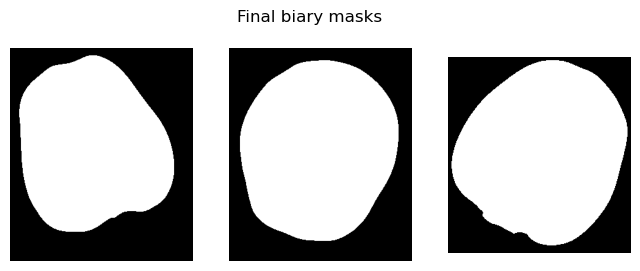

In [5]:
final_shapes = [cv2.medianBlur(img,19) for img in final_shapes]
cv_functions.show_fruit(final_shapes,8,3,'Final biary masks')

### Cut the NIR images from the background using the binary mask

For this operation was sufficient a multiplication between each NIR image and the corresponding binary mask.

Looking at the NIR images with the cutted background, all of them look pretty well.

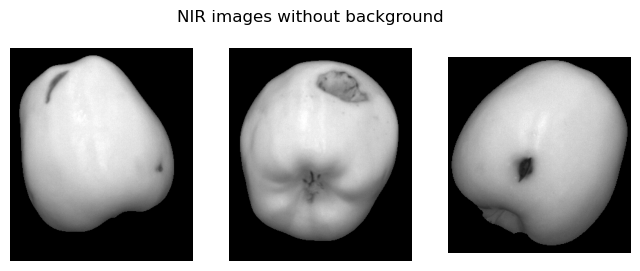

In [6]:
new_NIR_imgs = [cv_functions.cut_background(img, final_shapes[i], flag='nir') for i,img in enumerate(NIR_imgs)]
cv_functions.show_fruit(new_NIR_imgs,8,3, 'NIR images without background')

## Second part: search for the defects on each fruit

### Using the cutted images to compute the edges with the Canny edge detector

At this point I have only to locate the defects, so, since it is the most widespread, I used the Canny adge detector to get all the edges in each figure. 
OpenCV implements a non-complete version of this algorithm, infact, it doesn't use the Gaussian Blur used in the real algorithm before the edge detection step.
As it can be seen in the file 'cv_functions.py' my function 'get_edges' is structured to permit the following things:
* Passing None (the default value) to the parameter(s) 'filter_type' or 'filter_val' the output will be the edges detected by the OpenCV implementation of Canny;
* Passing 'gaussian' as 'filter_type' a gaussian blur will be applied before the Canny algorithm, obtaining the original formulation;
* Passing 'bilateral' as 'filetr_type' a bilateral filter will be applied before the Canny algorithm, obtaining a variation of the original algorithm.

In this particular task, the use of a bilateral filter (which preserves the edges better then a gaussian blur) permitted to identify all the defects excluding (as wanted) the sepals in the second image.

After the edge detection step, a little dilatation of the edges is used to make them more homogeneous and thus to improve the work done by the connectedComponents used by the 'get_defects' function.


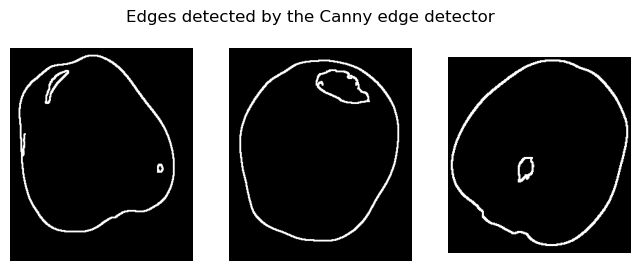

In [7]:
edges = [cv_functions.get_edges(img, 50, 120, 'bilateral', 11, 30, 30) for img in new_NIR_imgs] 
edges = [cv2.dilate(img,kernel =np.ones((3,3), np.uint8), iterations=1) for img in edges]
cv_functions.show_fruit(edges,8,3, 'Edges detected by the Canny edge detector')

### Removing the edge relative to the fruits' perimeters

The only remained thing is to remove the outer edge from all the images (because it is not a defect, it is the border of the fruit). To do so, I used the connected components algorithm to identify all the components, then, using an algorithm I exluded the borders of the fruits. The algorithm that I used to exclude the borders works as follow:
* After the connected components algorithm, for each detected component, an image which is complitely black but white in the pixels of the considered component is created;
* The flood-fil algorithm is then used on each generated image in order to fill with white each component, these binary masks are stored in a list called 'single_image_defects';
* A this point the area of each component is computet (using countNonZero of openCV) and stored in a list;
* Using the function argmax of numpy the index (called 'border_index') of the component with the larger area is computed. This area is the one relative to the edge of the entire fruit;
* At the end, all the masks inside the 'single_image_defects' list are merged with a bitwise-or, but exluding the one with the index equal to 'border_index'.

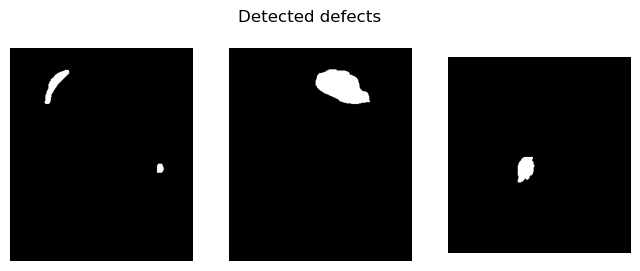

In [8]:
defects = [cv_functions.get_defects(edge) for edge in edges]
cv_functions.show_fruit(defects,8,3, 'Detected defects')

### Visualization of the defects

The next step is a dilatation done on each defect, this step can be omitted, but it has been done for visualization purposes, infact, it permits to draw a slightly bigger ellipse in the last step of this first task making the visualisation better.

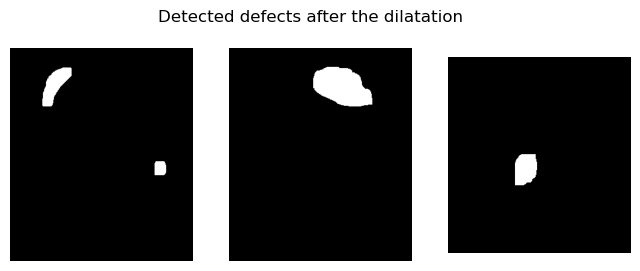

In [9]:
defects = [img.astype(np.uint8) for img in defects]
defects = [cv2.dilate(img,kernel =np.ones((3,3), np.uint8), iterations = 4) for img in defects]
cv_functions.show_fruit(defects,8,3,'Detected defects after the dilatation')

Each defect is now surrounded by a red ellipse. It is notable that there aren't neither false positives nor false negatives.

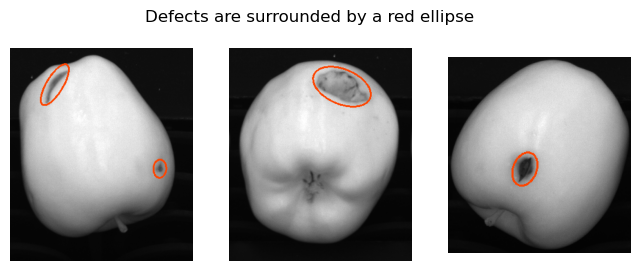

In [10]:
circled_nir_imgs =  cv_functions.draw_ellipses(defects,NIR_imgs, None)

cv_functions.show_fruit(circled_nir_imgs,8,3,'Defects are surrounded by a red ellipse')

# Second Task: russet detection

In this task the goal was to dectect some rusts on the surfaces of two apples using a color distance which can properly segment the rusty parts from the body of the fruits.

The difficulty is greater than in the first task. Just looking at the images, it's clear that the two apples have differnt body's color and different russet's color, making hard the creation of a general algorithm for both images.

For this task, obviously, I chose to use the colored images.

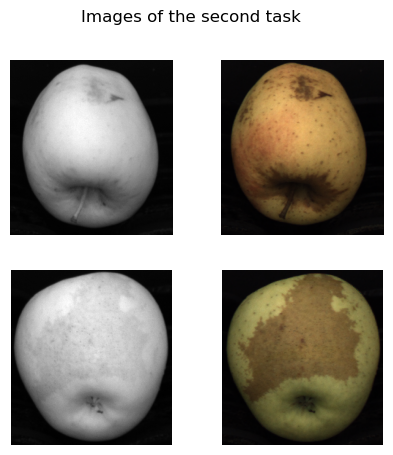

In [11]:
NIR_imgs, COLOR_imgs = cv_functions.load_images('second task', ['04', '05'])
#Plot images
cv_functions.show_fruit(NIR_imgs,5,5, 'Images of the second task', COLOR_imgs)

### Upload of the samples

The first step was to collect some samples from the rusty parts of each apple in order to have a reference colour to distinguish them from the non-rusty parts using a distance between colours. As explained previously the colours of the russets of the two apples are quite different, thus I chose to take samples from both.

Another possible approach could be the following: take samples of the non-rusty parts (i.e. the apples' bodies) and use them to distinguish the two parts. I discarded this idea because the first apple is yellow with also a red nuance, while the second apple is green.

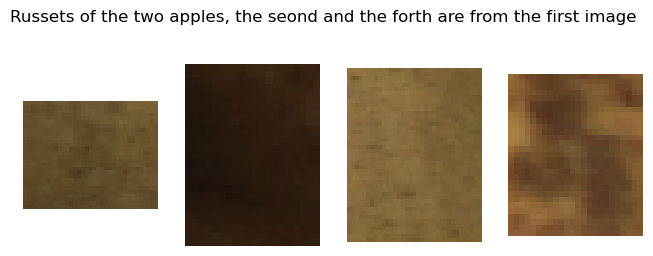

In [12]:
samples = [
cv2.cvtColor(cv2.imread("fruit-inspection-images/second task/samples/1.png", cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB),
cv2.cvtColor(cv2.imread("fruit-inspection-images/second task/samples/2.png", cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB),
cv2.cvtColor(cv2.imread("fruit-inspection-images/second task/samples/3.png", cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB),
cv2.cvtColor(cv2.imread("fruit-inspection-images/second task/samples/4.png", cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB)
]

cv_functions.show_fruit(samples,8,3, 'Russets of the two apples, the seond and the forth are from the first image')

### Using the mahalanobis distance to segment the rusty parts

The first thing that I tried was to use the mahalanobis distance to calculate the difference between the average color obtained from the samples and each pixel of the current image. If this difference is less than a threshold, the pixel is considered sufficiently similar to the reference color and so it's picked as russet. For each image, the procedure 'get_russet_mask' returns a binary mask which is white only in the pixels that have been identified as part of a russet.
The steps are these:
* Choose a color space (in this case RGB);
* Compute the mean color and the covariance matrix of the samples;
* Use the mean color, the covariance matrix and the colored images to compute the mahalanobis distance and then create the binary mask. 



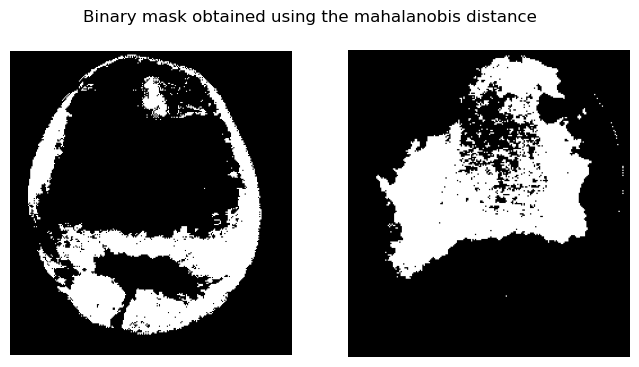

In [13]:
color_space = 'rgb'
russet_color_sample, covariance_matrix = cv_functions.get_mean_cov(samples,color_space) 
russet_masks = [cv_functions.get_russet_mask(covariance_matrix, color_space, russet_color_sample, img, 0.075) for img in COLOR_imgs]
cv_functions.show_fruit(russet_masks,8,4, 'Binary mask obtained using the mahalanobis distance')

For the second image I achieved very good results while in the first one not properly, the problems are:
* The part near the stem isn't recognized as russet, but this is not a big problem since the outher part of this rusty part has been recognized;
* The right border of the apple has been recognized as russet, probably because it is a shadow part and thus the color of the body of the apple is similar to the rusty part of the second apple;

Despite these problems, the 3 rusts (the one on top, the one arround the stem and the one on the left) have been recognized.

To achieve better results in this step I tried both to tune the distance threshold as well as the number/type of samples, but the results didn't improve. In particular, a lighter mean color lead to not well identify the rusts in the first image, since they are very dark, on the other hand, a darker color bring to not identify the rusts in the second image because they have a lighter color than the rusts in the first one.

### Showing the results

Once I had the binary masks of the rusts, I applied a median blur to make them more homogeneous before drawing some ellipses that surround the rusty parts.

While in the second image the result is very satisfactory, in the first one, due to the right border recognized as a rusty part, the algorithm shows a very big part as rusty, and this could be a problem. As an example, if this apple had not had the buttom russet, a rusty part would still been identified on the right side, it would have been a **False Positive**.

Thus, I tryed to improve this first solution.

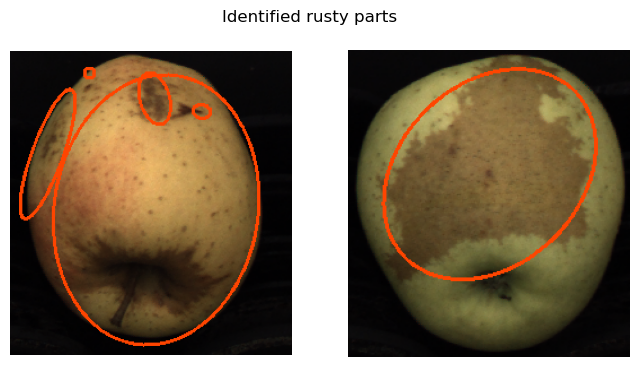

In [14]:
russet_masks_blurred = [cv2.medianBlur(img.astype(np.uint8),7) for img in russet_masks]
circled_color_imgs = cv_functions.draw_ellipses(russet_masks_blurred, COLOR_imgs, (9,9))

cv_functions.show_fruit(circled_color_imgs,8,4, 'Identified rusty parts')

## Trying to improve the results

### Using an erosion and a dilation

So, I tryed with an erosion followed by a dilatation directly on the mask with the median filter applied. My idea was to cut off a little part from the border of the apples and then apply a dilatation to highlight again the little rusts that the procedure might have shrunk.
The obtained results look better than before:
* The results on the second apple aren't changed (as wanted);
* On the first apple all the 3 rusty parts are now highlithed and the false positive part is much smaller than before.

To my mind this process can be used since it improve the performances and it and is not very aggressive (it is notable that all the rusts are still recognized).

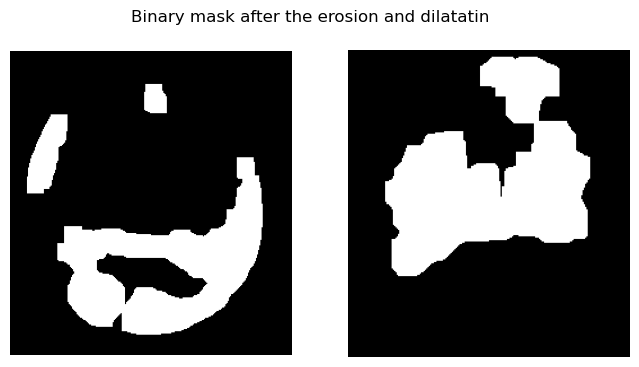

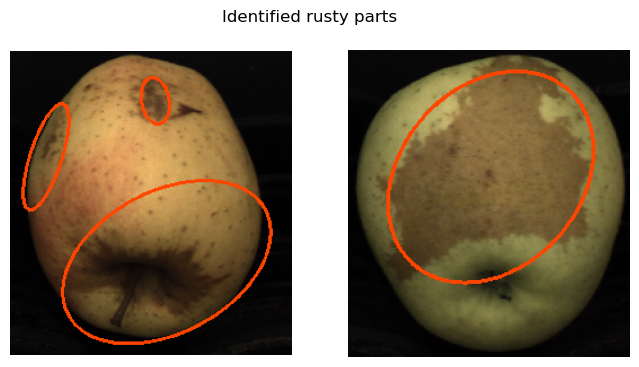

In [15]:
erosion_iterations = 5
russet_masks_eroded = [cv2.erode(img, np.ones((3,3), np.uint8), iterations = erosion_iterations) for img in russet_masks_blurred]
russet_masks_dilatated = [cv2.dilate(img,kernel =np.ones((3,3), np.uint8), iterations = 7) for img in russet_masks_eroded]
cv_functions.show_fruit(russet_masks_dilatated,8,4,'Binary mask after the erosion and dilatatin')
circled_color_imgs = cv_functions.draw_ellipses(russet_masks_dilatated, COLOR_imgs, (5,5))
cv_functions.show_fruit(circled_color_imgs,8,4, 'Identified rusty parts')

### Using others color spaces (HSV, HSL, LUV and LAB)

Using the above technique, I tryed also some different colour spaces, but the results changed very little. Only the HLS colour space shows slightly worse results. 

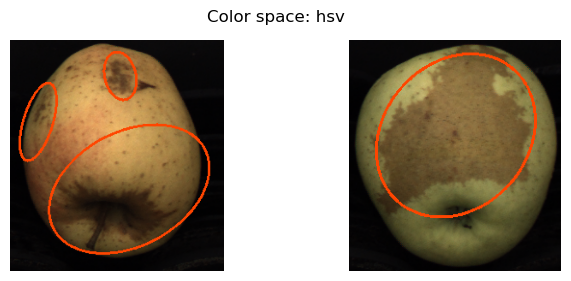

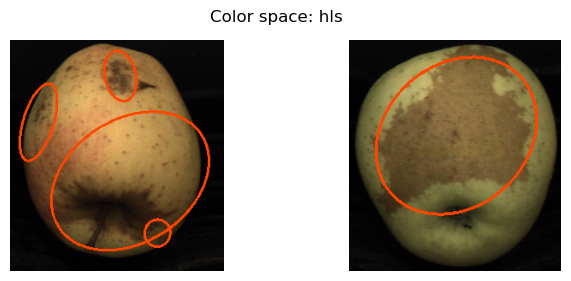

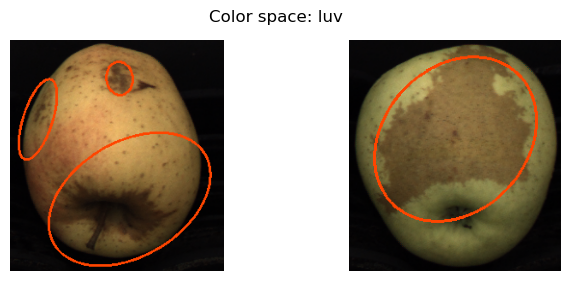

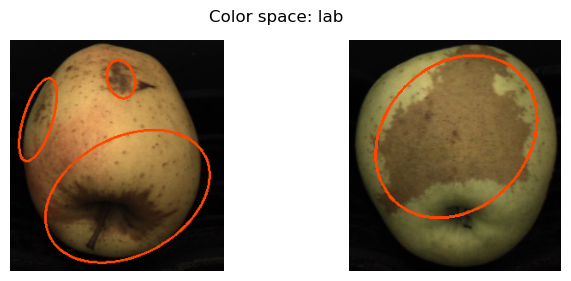

In [16]:
color_spaces = ['hsv', 'hls', 'luv','lab']
for color_space in color_spaces:
    russet_color_sample, covariance_matrix = cv_functions.get_mean_cov(samples,color_space)
    russet_masks = [cv_functions.get_russet_mask(covariance_matrix, color_space, russet_color_sample, img, 0.075) for img in COLOR_imgs]
    russet_masks_blurred = [cv2.medianBlur(img.astype(np.uint8),5) for img in russet_masks]
    russet_masks_eroded = [cv2.erode(img, np.ones((3,3), np.uint8), iterations = erosion_iterations) for img in russet_masks_blurred]
    russet_masks_dilatated = [cv2.dilate(img,kernel =np.ones((3,3), np.uint8), iterations = 7) for img in russet_masks_eroded]
    circled_color_imgs = cv_functions.draw_ellipses(russet_masks_dilatated, COLOR_imgs, (11,11))
    cv_functions.show_fruit(circled_color_imgs, 8, 3, f"Color space: {color_space}")



### Trying to use the euclidean distance

I tryed also to use the euclidean distance insted of the mahalanobis one, but the results (as the theory suggests) are worse.

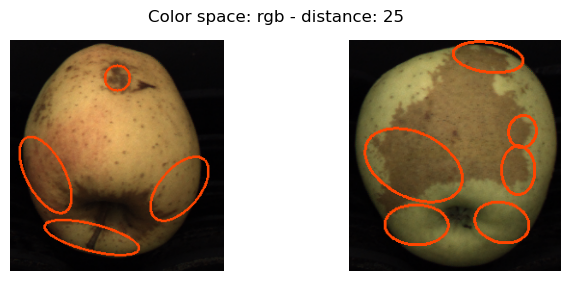

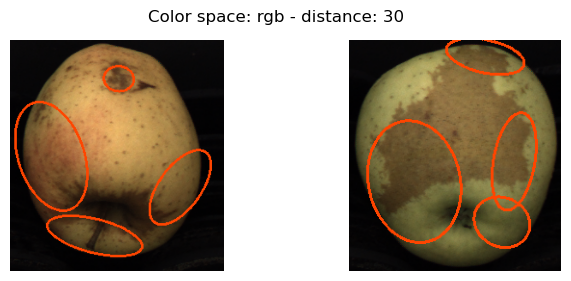

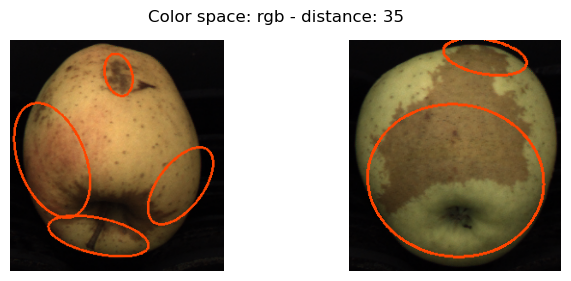

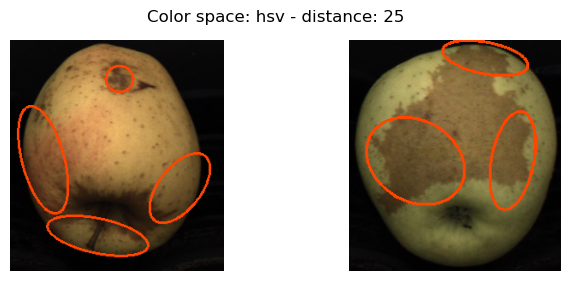

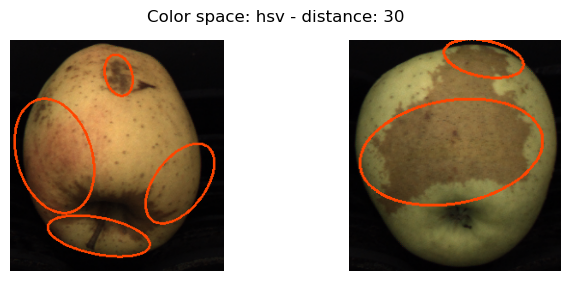

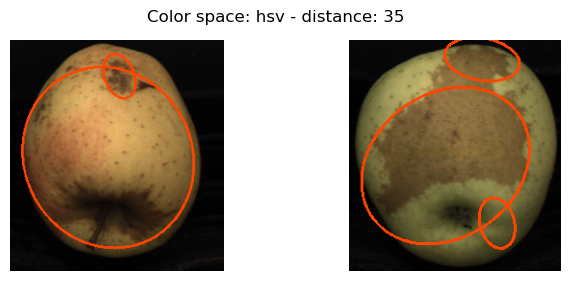

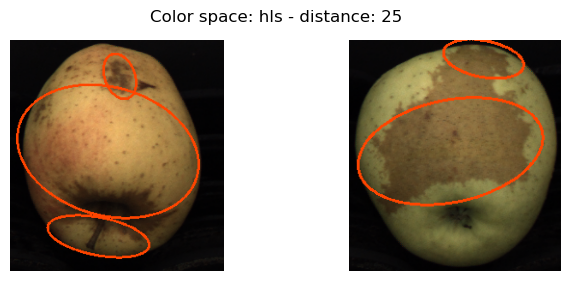

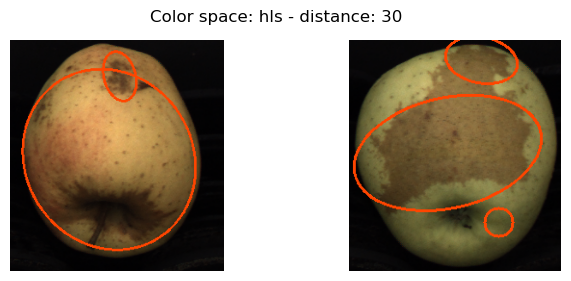

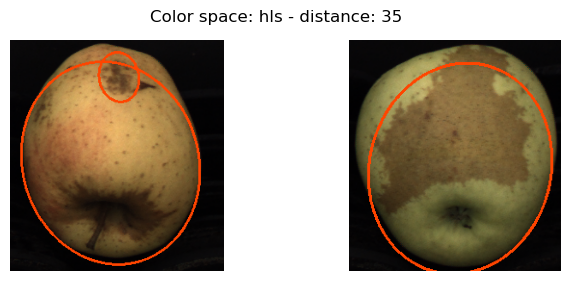

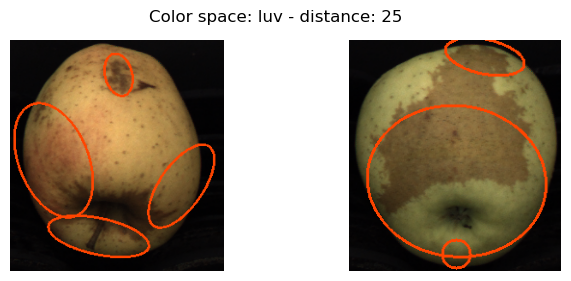

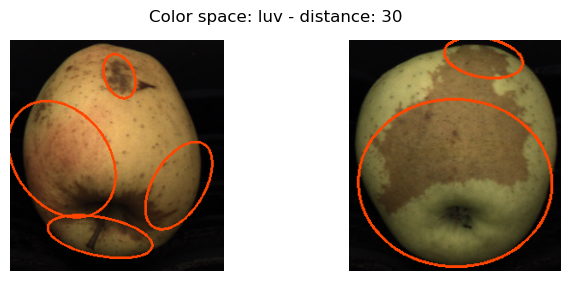

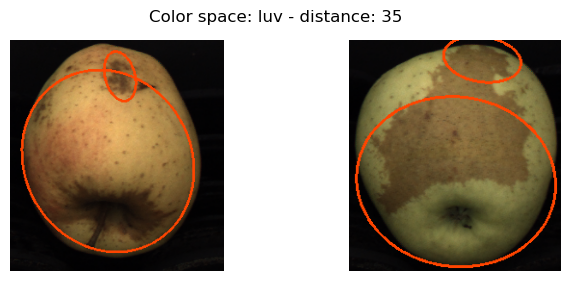

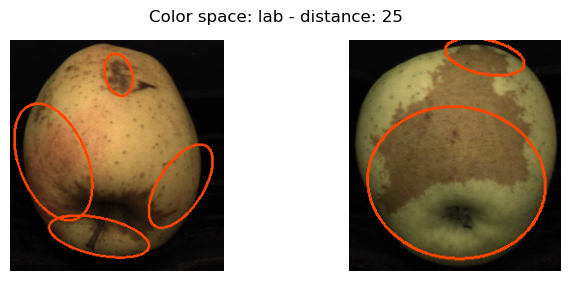

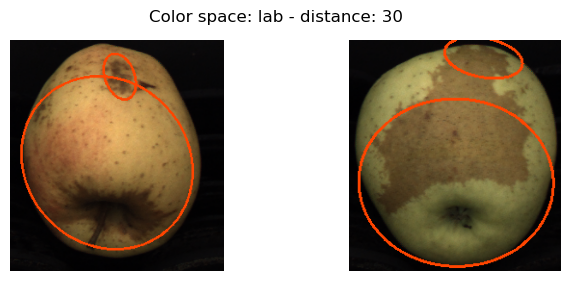

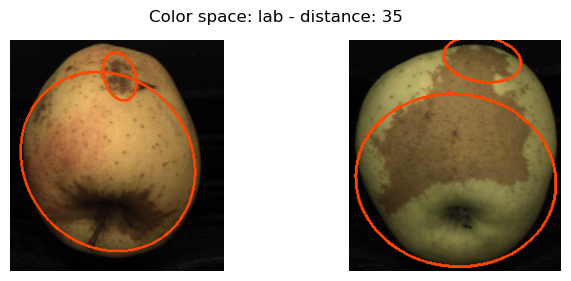

In [17]:
color_spaces = ['rgb','hsv', 'hls', 'luv', 'lab']
distances = [25,30,35]
for color_space in color_spaces:
    russet_color_sample, _ = cv_functions.get_mean_cov(samples,color_space)
    for d in distances:
        russet_masks = [cv_functions.get_russet_mask(_, color_space, russet_color_sample, img, d, 'euclidean') for img in COLOR_imgs]
        russet_masks_blurred = [cv2.medianBlur(img.astype(np.uint8),5) for img in russet_masks]
        russet_masks_eroded = [cv2.erode(img, np.ones((3,3), np.uint8), iterations = erosion_iterations) for img in russet_masks_blurred]
        russet_masks_dilatated = [cv2.dilate(img,kernel =np.ones((3,3), np.uint8), iterations = 7) for img in russet_masks_eroded]
        circled_color_imgs = cv_functions.draw_ellipses(russet_masks_dilatated, COLOR_imgs, (11,11))
        cv_functions.show_fruit(circled_color_imgs, 8, 3, f"Color space: {color_space} - distance: {d}")

## Using ad hoc samples for each apple

As last try, since the best result achieved is good but not perfect, I tried to use for each apple its russets as samples (here I also avoided the erosion followed by the dilatation on the binary masks).

Of course, this method is unusable in a real world application because it requires to take at least one sample from each apple, **but** the results with this approach are very good and for a real world application we can think to split the apples based on their colour.

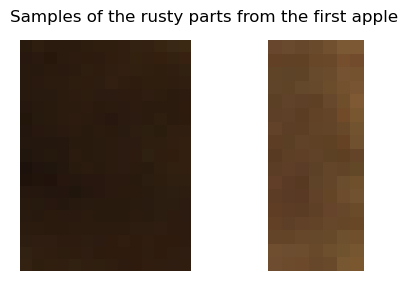

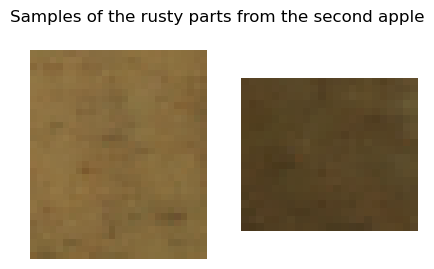

In [18]:
first_apple_samples = [
cv2.cvtColor(cv2.imread("fruit-inspection-images/second task/first_apple_samples/1.png", cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB),
cv2.cvtColor(cv2.imread("fruit-inspection-images/second task/first_apple_samples/2.png", cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB)
]
second_apple_samples = [
cv2.cvtColor(cv2.imread("fruit-inspection-images/second task/second_apple_samples/1.png", cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB),
cv2.cvtColor(cv2.imread("fruit-inspection-images/second task/second_apple_samples/2.png", cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB)
]
cv_functions.show_fruit(first_apple_samples,5,3, 'Samples of the rusty parts from the first apple')
cv_functions.show_fruit(second_apple_samples,5,3, 'Samples of the rusty parts from the second apple')

### Computing mean and covariance_matrix

I used the LUV color space since it is one of the best seeing at the experiments above. 

In [19]:
color_space = 'luv'
first_apple_mean_cov, second_apple_mean_cov = [cv_functions.get_mean_cov(first_apple_samples,color_space), cv_functions.get_mean_cov(second_apple_samples,color_space)]
russet_color_sample = [first_apple_mean_cov[0],second_apple_mean_cov[0]]
covariance_matrix = [first_apple_mean_cov[1],second_apple_mean_cov[1]]

### Using the mahalanobis distance to segment the rusty parts

I tuned the threshold based on the image.

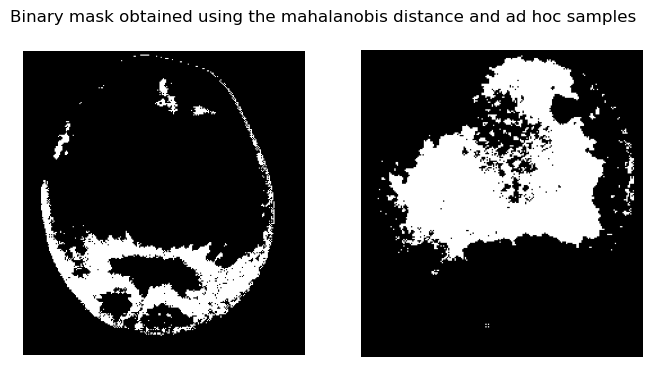

In [20]:
russet_masks = []
for i,color in enumerate(russet_color_sample):
    d = 0.3
    if i == 1:
        d = 0.15
    russet_masks.append(cv_functions.get_russet_mask(covariance_matrix[i], color_space, color, COLOR_imgs[i], d))


cv_functions.show_fruit(russet_masks,8,4, 'Binary mask obtained using the mahalanobis distance and ad hoc samples')

### Showing the results

As showed below, the result using ad hoc samples and threshold are perfect.

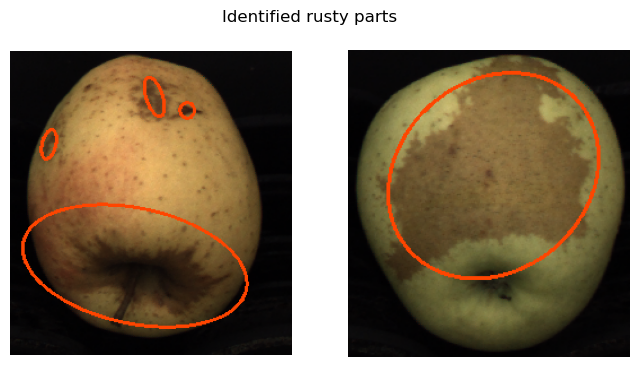

In [21]:
russet_masks_blurred = [cv2.medianBlur(img.astype(np.uint8),11) for img in russet_masks]
circled_color_imgs = cv_functions.draw_ellipses(russet_masks_blurred, COLOR_imgs, (9,9))
cv_functions.show_fruit(circled_color_imgs,8,4, 'Identified rusty parts')

# Final challenge: kiwi ispection

This task is very similar to the first one, since the aim was to outline some kiwis and then locate a defect on one of them.

the difficulty is given by the fact that the images are worse than in the first task, in all of them is visible the conveyor, in the first image there is a sticker and in two images is visible a background with a color very similar to the one of the kiwis.

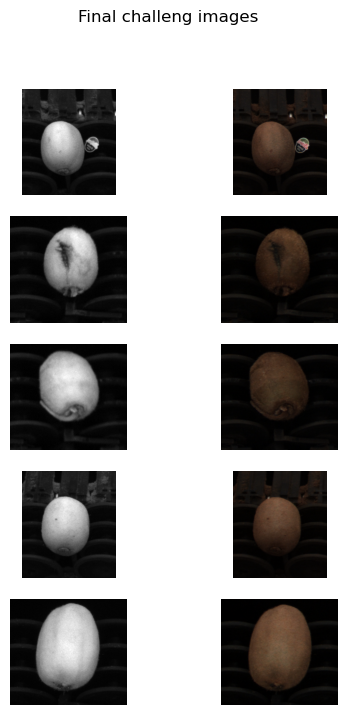

In [29]:
NIR_imgs, COLOR_imgs = cv_functions.load_images('final challenge', ['06', '07', '08', '09', '10'])

cv_functions.show_fruit(NIR_imgs,5,8,'Final challeng images',COLOR_imgs)

## Frtuit segmentation

The first part of the final challenge requires to segment the fruit in each image. At the beginning I tried with both the method based on thresholding and the one based on colours, but the results was bad.
The problems were 3:
* A sticker near the kiwi in the first image;
* The conveyor is well visible in all images;
* In some images is visible a part of the background with a color similar to the one of the kiwies.

All this factors made the two mentioned approaches quite ineffective.

My idea, so, was to merge the two approaces, in particular, the final pipeline works as follow:
* Threshold the NIR images to obtain a first binary mask with some errors (like the sticker in the first image), but useful to remove the background and the conveyor;
* Use this mask to cut the colored images from the backfround;
* Use the mahalanobis disntance approch of the second task to remove the sticker and other imperfections (I used the kiwi color as sample in order to keep the fruits and discard the other things)

### Parallax effect

Before going on, I'd like to talk a little bit about the parallax effect present between each NIR image and the corresponding colored image.
A big parallax effect in this last task could be a problem since I used both types of images to achieve the results, but, in this particular case, I did not encounter any problems since the effect is almost imperceptible.

### Uploading the sample

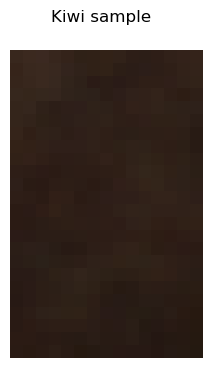

In [23]:
#kiwi sample used to separate the kiwi from the rest
samples = [
cv2.cvtColor(cv2.imread("fruit-inspection-images/final challenge/samples/1.png", cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB)
]
cv_functions.show_fruit(samples,4,4, 'Kiwi sample')

### Gray levels histograms

As for the first task, I used the gray level histograms to understand if it is possible to manually set a threshold. This time I computed the histograms on the images after the application of a bilateral filter since it helps to have a better thresholding by smoothing the images.

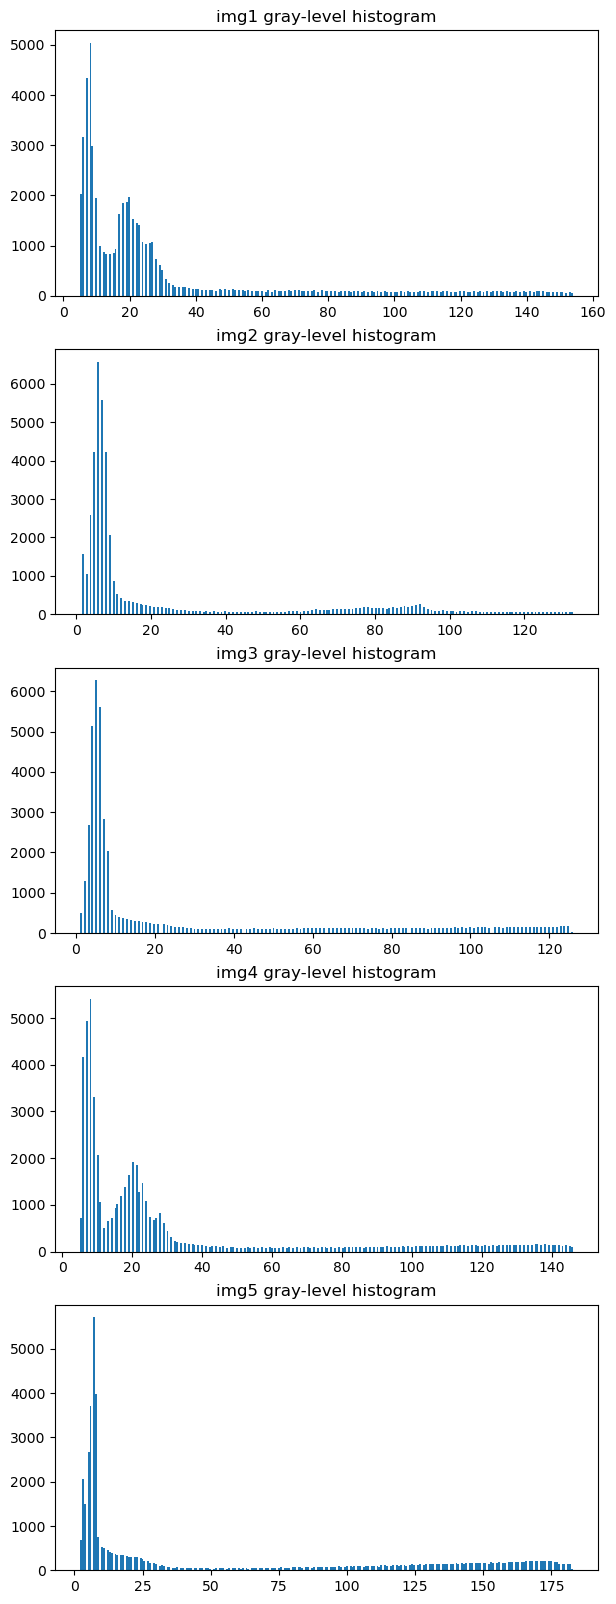

In [33]:
#Gray level histograms to understand if it is possible to use an hard-coded threshold
blurred_nir = [cv2.bilateralFilter(img,40,80,80) for img in NIR_imgs]
cv_functions.plot_hists(blurred_nir,(7,20))

### Applying the pipeline binarization plus color segmentation

As for the first task, here I tried both Otsu and the adaptive thresholding, but using a fixed value of 30 with a bilataral filter achieved the best results.
The decision to use a bilateral filter was made because, compared to a Gaussian filter, the edges are preserved but still the image is made more homogeneous.

Writing about the color segmentation, the procedure is the same did for the second task. 
After some tests, the RGB colour space was chosen since it gives the best results.

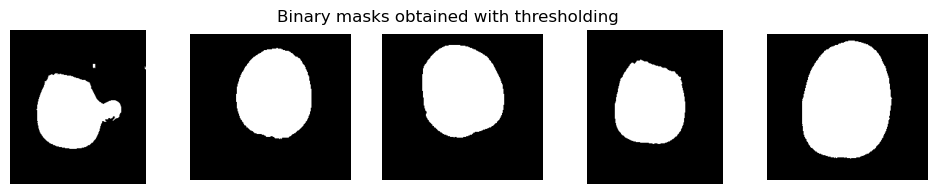

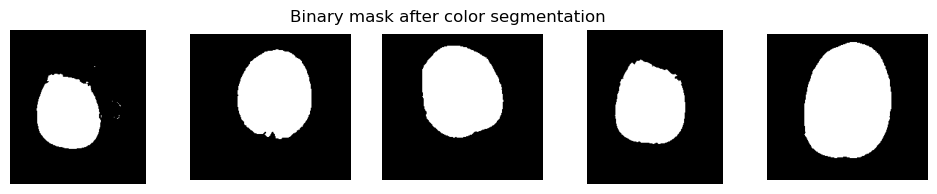

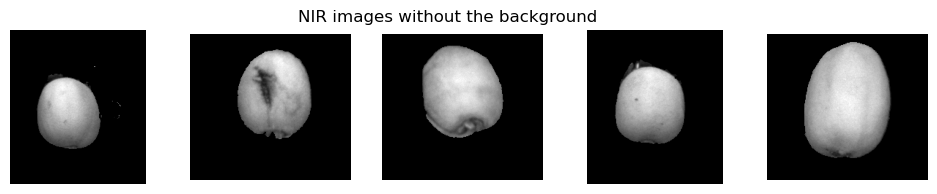

In [25]:
#Apply the thresholding to isolate the kiwis from its background and from other stuffs in the image
thresholded_imgs = [cv_functions.thresholding(img, 35) for img in blurred_nir]
flooded = [cv_functions.apply_flood_fil(img) for img in thresholded_imgs]
complete_shape = cv_functions.get_complete_shape(thresholded_imgs, flooded)
cv_functions.show_fruit(complete_shape, 12, 2,'Binary masks obtained with thresholding')

#Apply the color segmentation
color_space = 'rgb'
russet_color_sample, covariance_matrix = cv_functions.get_mean_cov(samples,color_space)
cutted_color = [cv_functions.cut_background(img,complete_shape[i],'rgb') for i,img in enumerate(COLOR_imgs)]
blurred_color = [cv2.GaussianBlur(img, (3,3), 2) for img in cutted_color]
russet_masks = [cv_functions.get_russet_mask(covariance_matrix, color_space, russet_color_sample, img,0.4) for img in blurred_color]

for i in range(len(russet_masks)):
    russet_masks[i] = (russet_masks[i]//255).astype(np.uint8)

#flooffil the masks obtainad to fill some holes
flooded = [cv_functions.apply_flood_fil(img) for img in russet_masks]
complete_shape = cv_functions.get_complete_shape(russet_masks, flooded)

#apply the masks 
new_NIR_imgs = [cv_functions.cut_background(img, complete_shape[i], flag='nir') for i,img in enumerate(NIR_imgs)]

cv_functions.show_fruit(complete_shape, 12, 2, 'Binary mask after color segmentation')
cv_functions.show_fruit(new_NIR_imgs, 12, 2, 'NIR images without the background')

### Showing the results

Before drawing the perimeter on the kiwis, a median blur is used to remove the last little imperfections from the background.

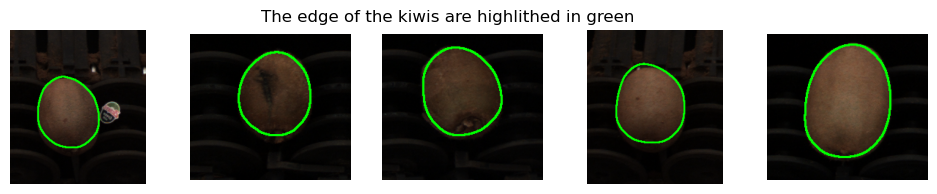

In [26]:
color_img_perimeter = []
median_complete_shape = []
for i,img in enumerate(complete_shape):
    #Apply a median blur to the masks to remove the last defects ftom the background
    median_complete_shape.append(cv2.medianBlur(img, 51).astype(np.uint8))
    contours, _ = cv2.findContours(median_complete_shape[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color_img_perimeter.append(COLOR_imgs[i].copy())
    cv2.polylines(color_img_perimeter[i], contours, True, (0,255,0), 2)
cv_functions.show_fruit(color_img_perimeter, 12, 2, 'The edge of the kiwis are highlithed in green')

The kiwis are identified and the results are satisfactory since only in one image also a very little part of the background is highlighted. 

## Locate the defect

### Edge detection

This last part was very straightforward. It was sufficent to cut the NIR images using the binary mask obtained at the end of the first part of this task and then proceed in the same way I did for the first task.

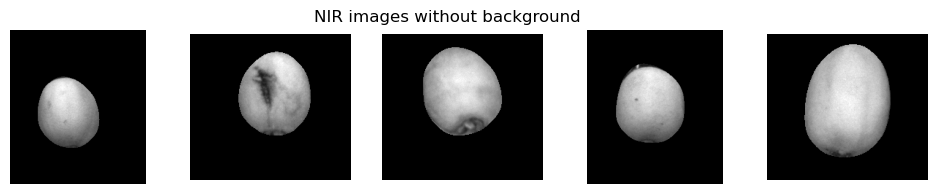

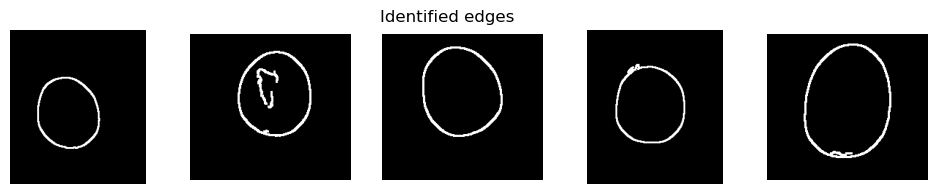

In [27]:
#remove the background from the NIR images
new_NIR_imgs = [cv_functions.cut_background(img, median_complete_shape[i], flag='nir') for i,img in enumerate(NIR_imgs)]
cv_functions.show_fruit(new_NIR_imgs, 12, 2, 'NIR images without background')

#Canny edge detector
edges = [cv_functions.get_edges(img, 1, 60, 'bilateral', 15, 50,80) for img in new_NIR_imgs]
edges = [cv2.dilate(img,kernel =np.ones((3,3), np.uint8), iterations=1) for img in edges]
cv_functions.show_fruit(edges, 12, 2, 'Identified edges')

### Showing the defects

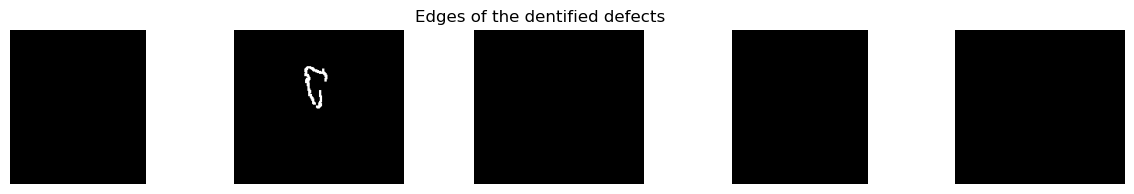

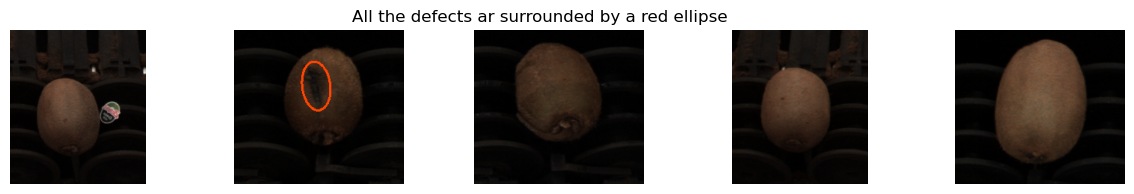

In [28]:
defects = [cv_functions.get_defects(edge) for edge in edges]

cv_functions.show_fruit(defects,15,2, 'Edges of the dentified defects')

defects = [img.astype(np.uint8) for img in defects]
defects = [cv2.dilate(img,kernel =np.ones((3,3), np.uint8), iterations = 4) for img in defects]
circled_nir_imgs = cv_functions.draw_ellipses(defects, COLOR_imgs, None)
cv_functions.show_fruit(circled_nir_imgs, 15, 2, 'All the defects ar surrounded by a red ellipse')

The result is the one wanted: The defect on the second image is highlighted and there aren't neither false positives nor false negatives.